# Simulating sampling

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
from skimage.data import shepp_logan_phantom
from skimage.transform import iradon, resize
import matplotlib.pyplot as plt
from nect.src.sampling.scikit_image import equidistant_sampling, golden_angle_sampling, dynamic_equidistant_sampling, dynamic_golden_angle_sampling
from nect.src.sampling.methods import equidistant, golden_angle
from nect.src.phantom.phantom_config import moving_objects_one_constant_changing_intensity_phantom
from nect.src.CT_simulator.scheduler import Scheduler

/cluster/home/henrfr/.local/lib/python3.10/site-packages/tqdm-4.66.1-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Comparing equidistant and golden angle sampling

In [4]:
img = resize(shepp_logan_phantom(), (256,256))
sinogram_equidistant, theta_equidistant = equidistant_sampling(img, 21, 1)
sinogram_golden, theta_golden = golden_angle_sampling(img, 21)

In [5]:
equidistant_reconstruction = iradon(sinogram_equidistant, theta=theta_equidistant, filter_name='ramp')
golden_reconstruction = iradon(sinogram_golden, theta=theta_golden, filter_name='ramp')

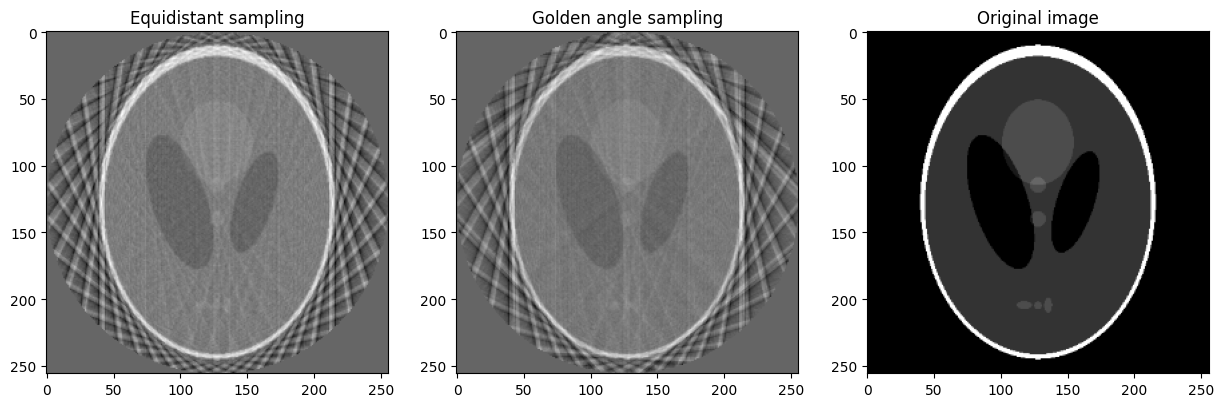

In [6]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(equidistant_reconstruction, cmap='gray')
axs[1].imshow(golden_reconstruction, cmap='gray')
axs[2].imshow(img, cmap='gray')
axs[0].set_title('Equidistant sampling')
axs[1].set_title('Golden angle sampling')
axs[2].set_title('Original image')
plt.show()

## Dynamic sampling

- We firstly define an "ideal" case, where the rotation speed is close to instantaneous.
- The Scheduler is responsible for updating the time between projections. It is set to move the phantom forward in time by 1 unit per full revolution.
- The Phantom is pre-defined and consists of multiple objects which changes position and intensity with time

In [2]:
scheduler = Scheduler(s_per_degree=1/360)
phantom = moving_objects_one_constant_changing_intensity_phantom()

In [8]:
# Sampling the pantom with 180 equidistant projections for 30 revolutions
sinogram, theta = dynamic_equidistant_sampling(phantom, scheduler, 180, 30)

Sampling:   1%|          | 47/5400 [00:00<00:34, 156.98it/s]

Sampling: 100%|██████████| 5400/5400 [00:25<00:00, 211.50it/s]


In [9]:
full_recon = iradon(sinogram, theta=theta, filter_name='ramp')

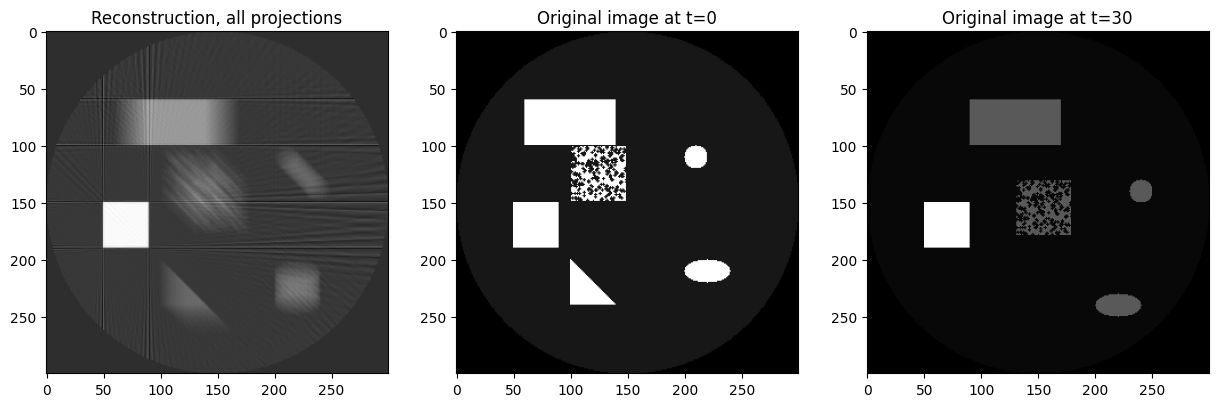

In [10]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(full_recon, cmap='gray')
axs[1].imshow(phantom.get_phantom(0), cmap='gray')
axs[2].imshow(phantom.get_phantom(30), cmap='gray')
axs[0].set_title('Reconstruction, all projections')
axs[1].set_title('Original image at t=0')
axs[2].set_title('Original image at t=30')
plt.show()

## Reconstruct and save a video for visual inspection

In [183]:
from nect.src.utils.video import save_video
import numpy as np

video_frames = []
steps = np.arange(0, 180*30, step = 180)
for i in range(len(steps)):
    video_frames.append(iradon(sinogram[:,steps[i]:steps[i]+180], theta=theta[steps[i]:steps[i]+180], filter_name='ramp'))

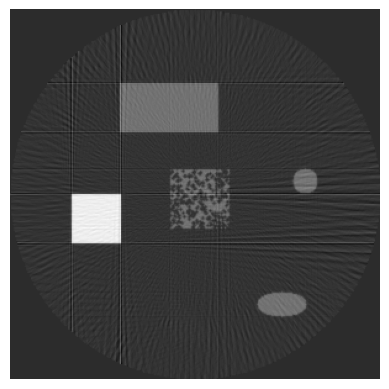

In [184]:
save_video(video_frames, 'equidistant_sampling.mp4', fps=2)

## Now using the Golden Angle sampling

It will still be an "ideal detector", but it will be undersampled using 1/4 of the equidistant projections

In [190]:
theta = golden_angle(45*30, radians=False)
scheduler_2 = Scheduler(s_per_degree=1/theta[45])  # Forcing the scheduler to use the same time per reconstruction timestep as the equidistant sampling

In [192]:
# Sampling the pantom with 45*30 equidistant projections for "30 time steps"
sinogram_2, theta_2 = dynamic_golden_angle_sampling(phantom, scheduler_2, 45*30)

Sampling: 100%|██████████| 1350/1350 [00:15<00:00, 88.61it/s]


In [194]:
full_recon_2 = iradon(sinogram_2, theta=theta_2, filter_name='ramp')

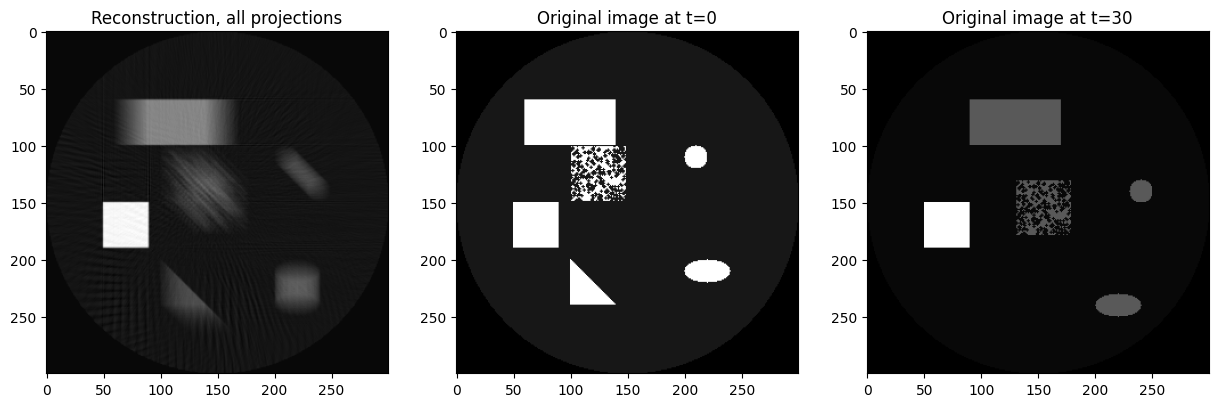

In [195]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(full_recon_2, cmap='gray')
axs[1].imshow(phantom.get_phantom(0), cmap='gray')
axs[2].imshow(phantom.get_phantom(30), cmap='gray')
axs[0].set_title('Reconstruction, all projections')
axs[1].set_title('Original image at t=0')
axs[2].set_title('Original image at t=30')
plt.show()

In [196]:
from nect.src.utils.video import save_video
import numpy as np

video_frames_2 = []
steps = np.arange(0, 45*30, step = 45)
for i in range(len(steps)):
    video_frames_2.append(iradon(sinogram_2[:,steps[i]:steps[i]+45], theta=theta_2[steps[i]:steps[i]+45], filter_name='ramp'))

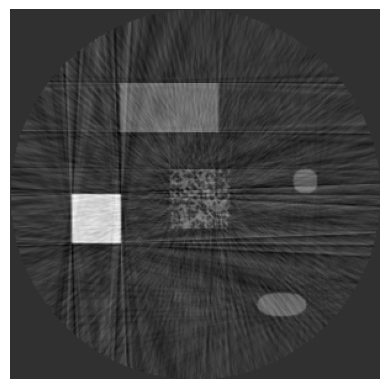

In [197]:
save_video(video_frames_2, 'golden_angle_sampling.mp4', fps=2)

## Using st-ssim

In [203]:
from pytorch_msssim import st_ssim
import torch

In [215]:
reference = phantom.create_video_as_tensor(np.arange(0,30,1))
reference = reference.unsqueeze(0).unsqueeze(0) / torch.max(reference)

Creating phantom images: 100%|██████████| 30/30 [00:00<00:00, 306.13it/s]


In [218]:
equidistant_tensor = (torch.tensor(video_frames).unsqueeze(0).unsqueeze(0) / torch.max(torch.tensor(video_frames))).float()
golden_angle_tensor = (torch.tensor(video_frames_2).unsqueeze(0).unsqueeze(0) / torch.max(torch.tensor(video_frames_2))).float()

In [220]:
print('Equidistant sampling: ', st_ssim(reference, equidistant_tensor, data_range=1.0))
print('Golden angle sampling: ', st_ssim(reference, golden_angle_tensor, data_range=1.0))

Equidistant sampling:  tensor(0.7091)
Golden angle sampling:  tensor(0.4703)


## Plotting st-ssim for different equidistant and golden angle projections

In [3]:
from tqdm import tqdm
import numpy as np
import torch
from nect.src.utils.video import save_video
VID_FRAMES = 30
reference = phantom.create_video_as_tensor(np.arange(0,VID_FRAMES,1))
reference = reference.unsqueeze(0).unsqueeze(0) / torch.max(reference)

methods = ["equidistant", "golden_angle"]
projections = [5, 7, 13, 17, 21, 45, 90, 135, 180, 270, 360]
#projections = [5, 21]
eq_stssim = []
golden_stssim = []
eq_vids = torch.zeros(size=(len(projections), VID_FRAMES, *phantom.size))
golden_vids = torch.zeros(size=(len(projections), VID_FRAMES, *phantom.size))
for method in methods:
    for i in tqdm(range(len(projections)), desc="Projections", position=0):
        if method == "equidistant":
            scheduler = Scheduler(s_per_degree=1/360)
            sinogram, theta = dynamic_equidistant_sampling(phantom, scheduler, projections[i], VID_FRAMES)  # 30 is the integer time steps of the phantom video
            print(scheduler.current_t)
        if method == "golden_angle":
            theta = golden_angle(projections[i]*VID_FRAMES, radians=False)
            scheduler = Scheduler(s_per_degree=1/theta[projections[i]])
            sinogram, theta = dynamic_golden_angle_sampling(phantom, scheduler, projections[i]*VID_FRAMES)
            print(scheduler.current_t)
        video_frames = np.zeros(shape=(VID_FRAMES, *phantom.size))
        steps = np.arange(0, projections[i]*VID_FRAMES, step = projections[i])
        for j in tqdm(range(len(steps)), desc="Reconstructing", position=1, leave=False):
            video_frames[j] = iradon(sinogram[:,steps[j]:steps[j]+projections[i]], theta=theta[steps[j]:steps[j]+projections[i]], filter_name='ramp')
        #save_video(video_frames, f'test_vids/{method}_sampling_{projections[i]}.mp4', fps=2)
        video_frames = torch.tensor(video_frames)
        tensor_vid = video_frames.unsqueeze(0).unsqueeze(0).float()
        tensor_vid /= torch.max(tensor_vid)
        if method == "equidistant":
            eq_vids[i] = video_frames
            #eq_stssim.append(st_ssim(reference, tensor_vid, data_range=1.0))
        if method == "golden_angle":
            golden_vids[i] = video_frames
            #golden_stssim.append(st_ssim(reference, tensor_vid, data_range=1.0))
torch.save(eq_vids, "eq_vids.pt")
torch.save(golden_vids, "golden_vids.pt")

Sampling: 100%|██████████| 150/150 [00:00<00:00, 188.43it/s]


29.88300835654601


Sampling: 100%|██████████| 210/210 [00:00<00:00, 216.86it/s]


29.94031038599277


Projections:  18%|█▊        | 2/11 [00:02<00:12,  1.43s/it]


KeyboardInterrupt: 

In [4]:
from pytorch_msssim import SSIM, ST_SSIM, MS_SSIM, ST_MS_SSIM
import torch

reference = phantom.create_video_as_tensor(np.arange(0,VID_FRAMES,1) + 0.5)
reference = reference.unsqueeze(1) / torch.max(reference)
ssim = SSIM(data_range=1.0, spatial_dims=2, channel=1)
st_ssim = ST_SSIM(data_range=1.0, spatial_dims=2, channel=1, temporal_win_size=3)
ms_ssim = MS_SSIM(data_range=1.0, spatial_dims=2, channel=1)
st_ms_ssim = ST_MS_SSIM(data_range=1.0, spatial_dims=2, channel=1, temporal_win_size=3)


eq_vids = torch.load("eq_vids.pt")
golden_vids = torch.load("golden_vids.pt")

eq_st_ssim_ = []
golden_st_ssim_ = []
eq_ssim_ = []
golden_ssim_ = []
eq_st_ms_ssim_ = []
golden_st_ms_ssim_ = []
eq_ms_ssim_ = []
golden_ms_ssim_ = []
for i in range(eq_vids.shape[0]):
    equidistant_recon = (eq_vids[i]).unsqueeze(1).float() / torch.max(eq_vids[i])  # Scaling and setting shape to [N=T, C, H, W]
    golden_recon = (golden_vids[i]).unsqueeze(1).float() / torch.max(golden_vids[i])
    eq_ssim_.append(ssim.forward(equidistant_recon, reference))
    golden_ssim_.append(ssim.forward(golden_recon, reference))
    eq_ms_ssim_.append(ms_ssim.forward(equidistant_recon, reference))
    golden_ms_ssim_.append(ms_ssim.forward(golden_recon, reference))

    reference = reference.permute(1,0,2,3).unsqueeze(0)  # Setting shape to [N,C,T,H,W]
    equidistant_recon = equidistant_recon.permute(1,0,2,3).unsqueeze(0)
    golden_recon = golden_recon.permute(1,0,2,3).unsqueeze(0)
    eq_st_ssim_.append(st_ssim.forward(equidistant_recon, reference))
    golden_st_ssim_.append(st_ssim.forward(golden_recon, reference))
    eq_st_ms_ssim_.append(st_ms_ssim.forward(equidistant_recon, reference))
    golden_st_ms_ssim_.append(st_ms_ssim.forward(golden_recon, reference))
    reference = reference.squeeze(0).permute(1,0,2,3)  # Setting reference shape back to [N=T, C, H, W]


Creating phantom images: 100%|██████████| 30/30 [00:00<00:00, 132.46it/s]
/cluster/home/henrfr/.conda/envs/master/lib/python3.10/site-packages/pytorch_msssim/ssim.py:426: UserWarning: Temporal dimension size should be larger than 32 due to the 4 downsamplings in ms-ssim
  warnings.warn("Temporal dimension size should be larger than %d due to the 4 downsamplings in ms-ssim" % ((temporal_win_size - 1) * (2 ** 4)))


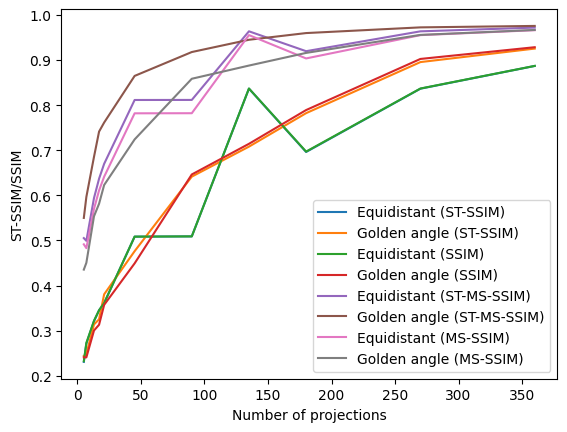

In [5]:
plt.plot(projections, eq_st_ssim_, label="Equidistant (ST-SSIM)")
plt.plot(projections, golden_st_ssim_, label="Golden angle (ST-SSIM)")
plt.plot(projections, eq_ssim_, label="Equidistant (SSIM)")
plt.plot(projections, golden_ssim_, label="Golden angle (SSIM)")
plt.plot(projections, eq_st_ms_ssim_, label="Equidistant (ST-MS-SSIM)")
plt.plot(projections, golden_st_ms_ssim_, label="Golden angle (ST-MS-SSIM)")
plt.plot(projections, eq_ms_ssim_, label="Equidistant (MS-SSIM)")
plt.plot(projections, golden_ms_ssim_, label="Golden angle (MS-SSIM)")
plt.xlabel("Number of projections")
plt.ylabel("ST-SSIM/SSIM")
plt.legend()
plt.show()